In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/Updated_Cosmetic_Orders.csv'
data = pd.read_csv(file_path)

# Drop the 'Unit Price' column (if it exists)
if 'Unit Price' in data.columns:
    data = data.drop(columns=['Unit Price'])

# Standardize the date format
data['Order Date'] = pd.to_datetime(data['Order Date'], errors='coerce').dt.strftime('%Y-%m-%d')

# Create separate columns for each item type with binary indicators
item_type_dummies = pd.get_dummies(data['Item Type'], prefix='Item_Type')
data = pd.concat([data, item_type_dummies], axis=1)

# Drop the original 'Item Type' column
if 'Item Type' in data.columns:
    data = data.drop(columns=['Item Type'])

# Replace the binary values in item type columns with corresponding quantities
for item_type in item_type_dummies.columns:
    data[item_type] = data[item_type] * data['Quantity']

# Drop the original 'Quantity' column as it's now distributed
data = data.drop(columns=['Quantity'])

# Combine multiple rows with the same 'Order Number'
grouped_data = data.groupby('Order Number').agg({
    'Order Date': 'first',                # Keep the first date for each order number
    'Total Price': 'sum',                 # Sum up the total prices
    'Courier Name': 'first',              # Keep the first courier name
    'Customer Type': 'first',             # Keep the first customer type
    'Region': 'first',                    # Keep the first region
    'Urban/Rural': 'first',               # Keep the first urban/rural value
    'Outcome': 'first',                   # Keep the first outcome
    'Item_Type_Cream': 'sum',             # Sum quantities of cream
    'Item_Type_Liquid': 'sum',            # Sum quantities of liquid
    'Item_Type_Powder': 'sum'             # Sum quantities of powder
}).reset_index()

# Display the updated dataset structure
print(grouped_data.head(10))


   Order Number  Order Date  Total Price Courier Name Customer Type  \
0          1002  2024-01-02         3184          M&P    First-time   
1          1003  2024-01-05         9021          TCS    First-time   
2          1004  2024-01-07         2056          M&P        Repeat   
3          1005  2024-01-09         4488       BlueEx        Repeat   
4          1006  2024-01-10         6808       BlueEx        Repeat   
5          1007  2024-01-11        16852       BlueEx        Repeat   
6          1008  2024-01-12         8438          TCS        Repeat   
7          1009  2024-01-13        13905          TCS    First-time   
8          1010  2024-01-15         3408       BlueEx    First-time   
9          1011  2024-01-16        12563          M&P    First-time   

       Region Urban/Rural               Outcome  Item_Type_Cream  \
0  Faisalabad       Urban          Not Received                0   
1  Faisalabad       Rural  Wrong Item Delivered                8   
2  Rawalpindi 

In [ ]:
grouped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Order Number      4635 non-null   int64 
 1   Order Date        4635 non-null   object
 2   Total Price       4635 non-null   int64 
 3   Courier Name      4635 non-null   object
 4   Customer Type     4635 non-null   object
 5   Region            4635 non-null   object
 6   Urban/Rural       4635 non-null   object
 7   Outcome           4635 non-null   object
 8   Item_Type_Cream   4635 non-null   int64 
 9   Item_Type_Liquid  4635 non-null   int64 
 10  Item_Type_Powder  4635 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 398.4+ KB


In [ ]:
# Write the updated dataset to a new CSV file
output_file_path = '/content/Processed_Cosmetic_Orders.csv'
grouped_data.to_csv(output_file_path, index=False)

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler

# Load the dataset
file_path = '/content/Processed_Cosmetic_Orders.csv'
data = pd.read_csv(file_path)

# Columns for one-hot encoding (exclude 'Outcome' from here)
one_hot_columns = ['Courier Name', 'Customer Type', 'Region', 'Urban/Rural']

# Apply one-hot encoding (full rank, no columns dropped)
one_hot_encoder = OneHotEncoder(sparse_output=False)  # Full rank encoding
one_hot_encoded = one_hot_encoder.fit_transform(data[one_hot_columns])
one_hot_df = pd.DataFrame(
    one_hot_encoded,
    columns=one_hot_encoder.get_feature_names_out(one_hot_columns)
)

# Drop original one-hot encoded columns and concatenate new ones
data = pd.concat([data.drop(columns=one_hot_columns), one_hot_df], axis=1)

# Apply label encoding to 'Outcome' column
label_encoder = LabelEncoder()
data['Outcome'] = label_encoder.fit_transform(data['Outcome'])

# Apply Min-Max scaling on all numeric columns (including Item Type columns)
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

# Drop specified columns
columns_to_drop = ['Region_Multan', 'Courier Name_Pakistan Post', 'Customer Type_Repeat',
                   'Outcome_Okay', 'Urban/Rural_Rural']
data = data.drop(columns=columns_to_drop, errors='ignore')  # errors='ignore' will avoid errors if any columns don't exist

# Save the transformed dataset to a new CSV file
output_file_path = '/content/Processed_Cosmetic_Orders_Transformed.csv'
data.to_csv(output_file_path, index=False)

print(f"Transformed data saved to: {output_file_path}")


Transformed data saved to: /content/Processed_Cosmetic_Orders_Transformed.csv


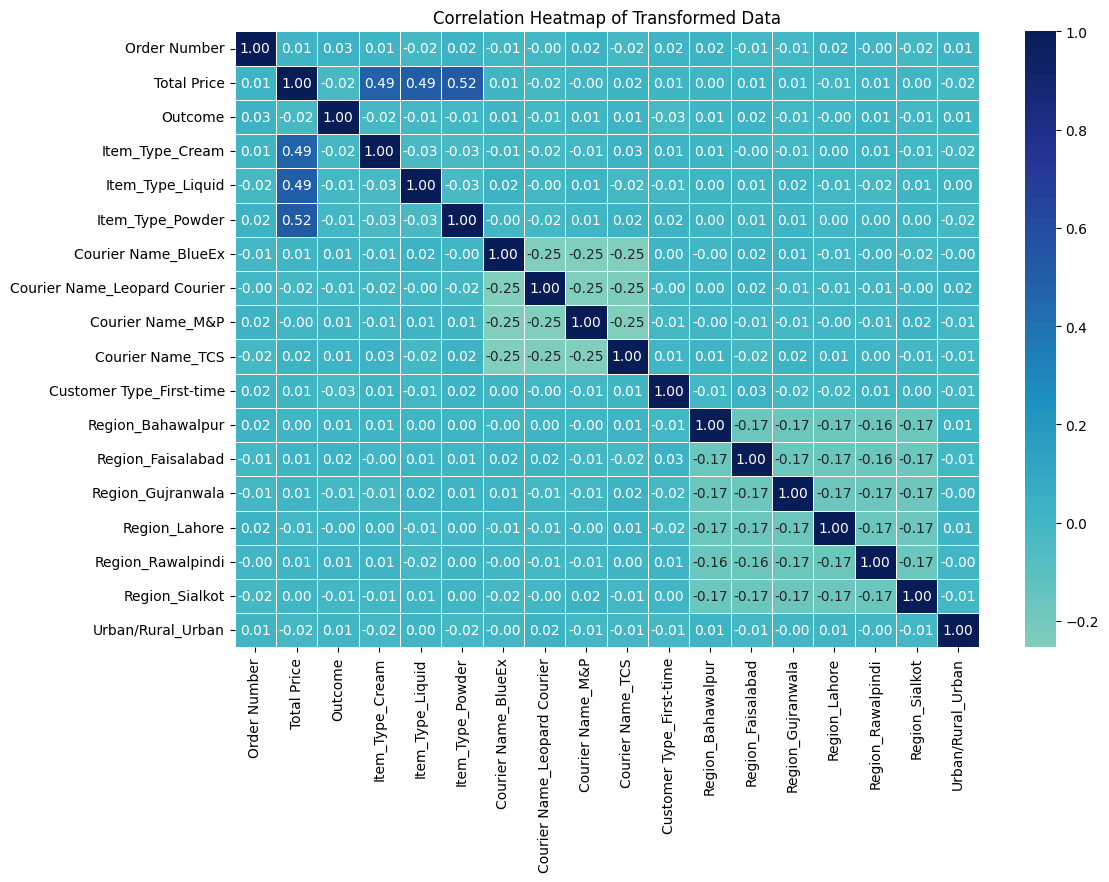

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the transformed dataset
file_path = '/content/Processed_Cosmetic_Orders_Transformed.csv'
data = pd.read_csv(file_path)

# Select only numeric columns for correlation calculation
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Remove constant columns (columns with zero variance)
numeric_data = numeric_data.loc[:, numeric_data.var() > 0]

# Compute the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap to visualize correlations
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5, center=0)
plt.title('Correlation Heatmap of Transformed Data')
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:07:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:07:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:08:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Logistic Regression:
               precision    recall  f1-score   support

           0       0.26      0.33      0.30       255
           1       0.22      0.21      0.22       225
           2       0.24      0.19      0.21       220
           3       0.22      0.22      0.22       227

    accuracy                           0.24       927
   macro avg       0.24      0.24      0.24       927
weighted avg       0.24      0.24      0.24       927



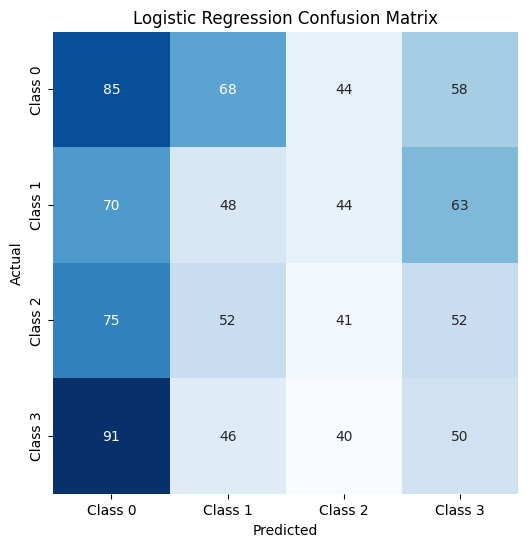

Decision Tree:
               precision    recall  f1-score   support

           0       0.23      0.19      0.21       255
           1       0.25      0.28      0.26       225
           2       0.24      0.25      0.24       220
           3       0.27      0.28      0.28       227

    accuracy                           0.25       927
   macro avg       0.25      0.25      0.25       927
weighted avg       0.25      0.25      0.25       927



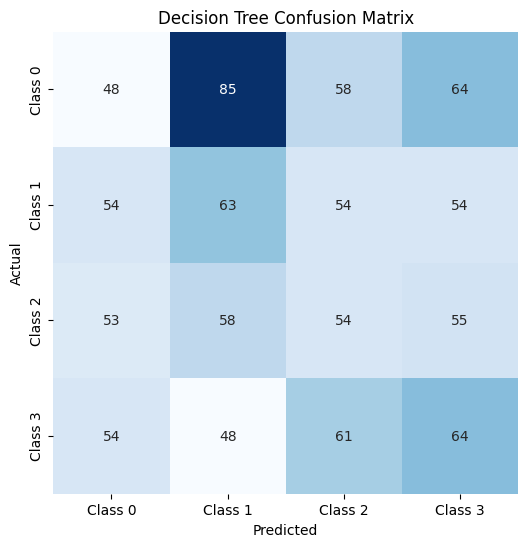

Random Forest:
               precision    recall  f1-score   support

           0       0.26      0.24      0.25       255
           1       0.20      0.23      0.22       225
           2       0.22      0.20      0.21       220
           3       0.27      0.29      0.28       227

    accuracy                           0.24       927
   macro avg       0.24      0.24      0.24       927
weighted avg       0.24      0.24      0.24       927



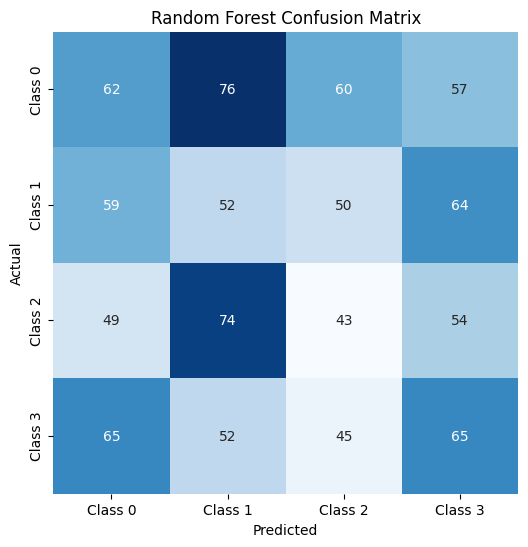

Gradient Boosting Machine:
               precision    recall  f1-score   support

           0       0.24      0.21      0.22       255
           1       0.26      0.29      0.27       225
           2       0.27      0.24      0.25       220
           3       0.23      0.26      0.24       227

    accuracy                           0.25       927
   macro avg       0.25      0.25      0.25       927
weighted avg       0.25      0.25      0.25       927



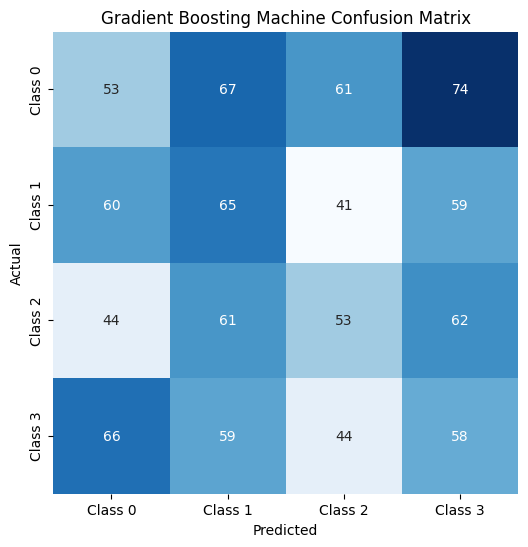

XGBoost:
               precision    recall  f1-score   support

           0       0.23      0.20      0.21       255
           1       0.24      0.25      0.25       225
           2       0.24      0.25      0.25       220
           3       0.26      0.27      0.26       227

    accuracy                           0.24       927
   macro avg       0.24      0.24      0.24       927
weighted avg       0.24      0.24      0.24       927



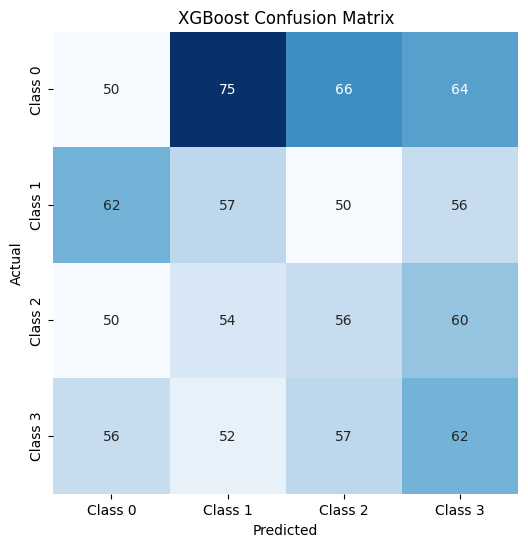

Stacking Classifier:
               precision    recall  f1-score   support

           0       0.26      0.27      0.26       255
           1       0.24      0.29      0.26       225
           2       0.25      0.28      0.27       220
           3       0.27      0.18      0.21       227

    accuracy                           0.25       927
   macro avg       0.26      0.25      0.25       927
weighted avg       0.26      0.25      0.25       927



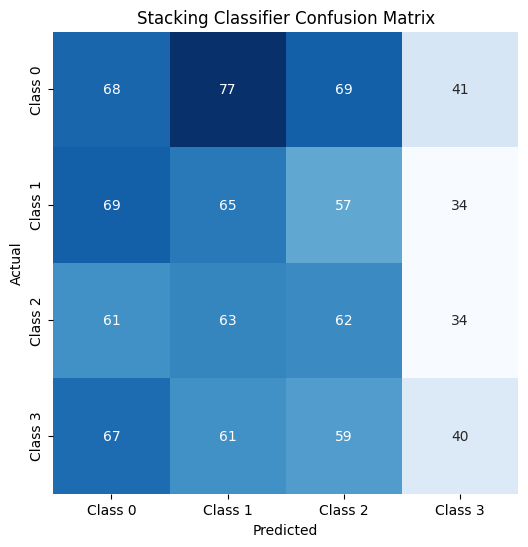

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=45)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression with class weight
logistic_regression = LogisticRegression(class_weight='balanced', max_iter=2000)
logistic_regression.fit(X_resampled, y_resampled)
y_pred_logistic = logistic_regression.predict(X_test_scaled)

# Decision Tree with class weight
decision_tree = DecisionTreeClassifier(class_weight='balanced', random_state=45)
decision_tree.fit(X_resampled, y_resampled)
y_pred_tree = decision_tree.predict(X_test_scaled)

# Random Forest with class weight
random_forest = RandomForestClassifier(class_weight='balanced', random_state=45)
random_forest.fit(X_resampled, y_resampled)
y_pred_forest = random_forest.predict(X_test_scaled)

# Gradient Boosting Machine
gbm = GradientBoostingClassifier(random_state=45)
gbm.fit(X_resampled, y_resampled)
y_pred_gbm = gbm.predict(X_test_scaled)

# XGBoost
xgboost = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=45)
xgboost.fit(X_resampled, y_resampled)
y_pred_xgboost = xgboost.predict(X_test_scaled)

# Ensemble Learning (Stacking)
# Base models
base_learners = [
    ('logistic_regression', LogisticRegression(class_weight='balanced', max_iter=2000)),
    ('decision_tree', DecisionTreeClassifier(class_weight='balanced', random_state=45)),
    ('random_forest', RandomForestClassifier(class_weight='balanced', random_state=45)),
    ('gbm', GradientBoostingClassifier(random_state=45)),
    ('xgboost', XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=45))
]

# Stacking Classifier with Logistic Regression as meta-model
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())
stacking_model.fit(X_resampled, y_resampled)
y_pred_stacking = stacking_model.predict(X_test_scaled)

# Define a function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=["Class 0", "Class 1", "Class 2", "Class 3"],
                yticklabels=["Class 0", "Class 1", "Class 2", "Class 3"])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Print classification reports and plot confusion matrices for each model
print("Logistic Regression:\n", classification_report(y_test, y_pred_logistic))
plot_confusion_matrix(y_test, y_pred_logistic, "Logistic Regression Confusion Matrix")

print("Decision Tree:\n", classification_report(y_test, y_pred_tree))
plot_confusion_matrix(y_test, y_pred_tree, "Decision Tree Confusion Matrix")

print("Random Forest:\n", classification_report(y_test, y_pred_forest))
plot_confusion_matrix(y_test, y_pred_forest, "Random Forest Confusion Matrix")

print("Gradient Boosting Machine:\n", classification_report(y_test, y_pred_gbm))
plot_confusion_matrix(y_test, y_pred_gbm, "Gradient Boosting Machine Confusion Matrix")

print("XGBoost:\n", classification_report(y_test, y_pred_xgboost))
plot_confusion_matrix(y_test, y_pred_xgboost, "XGBoost Confusion Matrix")

print("Stacking Classifier:\n", classification_report(y_test, y_pred_stacking))
plot_confusion_matrix(y_test, y_pred_stacking, "Stacking Classifier Confusion Matrix")


In [ ]:
import numpy as np

# Assuming y_train is a numpy array
unique_classes, class_counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique_classes, class_counts))

print(class_distribution)


{0: 914, 1: 916, 2: 919, 3: 959}


In [ ]:
# Assuming class 0 = 'Received', 1 = 'Not Received', 2 = 'Damaged', 3 = 'Wrong Item Delivered'
class_names = {0: 'Received', 1: 'Not Received', 2: 'Damaged', 3: 'Wrong Item Delivered'}

# Get the unique classes and their counts
unique_classes, class_counts = np.unique(y_train, return_counts=True)

# Map the class numbers to their names
class_distribution = {class_names[cls]: count for cls, count in zip(unique_classes, class_counts)}

print(class_distribution)


{'Received': 914, 'Not Received': 916, 'Damaged': 919, 'Wrong Item Delivered': 959}


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.32      0.26      0.29       256
     Class 0       0.28      0.15      0.20       241
     Class 0       0.27      0.21      0.23       219
     Class 1       0.24      0.48      0.32       211

    accuracy                           0.27       927
   macro avg       0.28      0.27      0.26       927
weighted avg       0.28      0.27      0.26       927



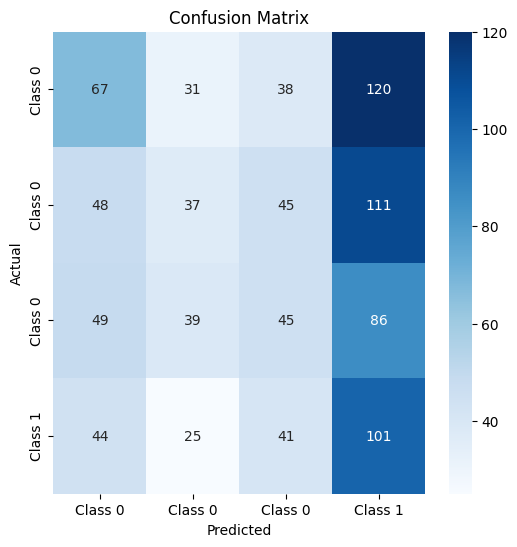

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
file_path = '/content/Processed_Cosmetic_Orders_Transformed.csv'
data = pd.read_csv(file_path)

# Convert 'Order Date' to a numeric feature (e.g., days since 1/1/2000)
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Days_Since_Order'] = (data['Order Date'] - pd.Timestamp('2000-01-01')).dt.days

# Drop the original 'Order Date' column
data.drop('Order Date', axis=1, inplace=True)

# Define the features (X) and target (y)
X = data.drop('Outcome', axis=1)  # Drop the target column to keep only features
y = data['Outcome']  # Assign the target column to y

# Step 1: Encode target labels if necessary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=50)

# Step 3: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Train Logistic Regression
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)
log_reg.fit(X_train_scaled, y_train)

# Step 5: Make Predictions
y_pred = log_reg.predict(X_test_scaled)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[f"Class {int(cls)}" for cls in label_encoder.classes_]))

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_test, y_pred, [f"Class {int(cls)}" for cls in label_encoder.classes_])
